## 1.2 Ideal single camera calibration using DLT and random points

**In this script, we intend to obtain an ideal calibration( meaning 0 error) with DLT without normalization.**\
 In order to achieve that it is important to know the calibration matrix in advance. Otherwise, if we generate world points and image points at random with the purpose of finding the projection matrix, the points generate might not have real use correspondence.


When dealing with an uncalibrated camera, 11 parameters are unknown, meaning we need at least **6 points** and assume the model of the camera is **affine**.
>**Problem specification:**
- Estimate the 11 elements of P given:
    - 3D coordinates $X_{i}$ of I $\geq$ 6 object points


<img src="/home/alegria/calibration/images/camera_orientation.png" width=400 height=400 />\


**Import libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np

DECIMALS = 2  # how many decimal places to use in print



### Set of Functions

In [2]:
def to_inhomogeneous(X: np.ndarray) -> np.ndarray:
    if X.ndim > 1:
        raise ValueError("x must be one-dimensional.")

    return (X / X[-1])[:-1]


def to_homogeneous(X: np.ndarray) -> np.ndarray:
    if X.ndim > 1:
        raise ValueError("X must be one-dimensional.")

    return np.hstack([X, 1])


def _get_roll_matrix(theta_x: float = 0.0) -> np.ndarray:
    Rx = np.array(
        [
            [1.0, 0.0, 0.0],
            [0.0, np.cos(theta_x), -np.sin(theta_x)],
            [0.0, np.sin(theta_x), np.cos(theta_x)],
        ]
    )
    return Rx


def _get_pitch_matrix(theta_y: float = 0.0) -> np.ndarray:
    Ry = np.array(
        [
            [np.cos(theta_y), 0.0, np.sin(theta_y)],
            [0.0, 1.0, 0.0],
            [-np.sin(theta_y), 0.0, np.cos(theta_y)],
        ]
    )
    return Ry


def _get_yaw_matrix(theta_z: float = 0.0) -> np.ndarray:
    Rz = np.array(
        [
            [np.cos(theta_z), -np.sin(theta_z), 0.0],
            [np.sin(theta_z), np.cos(theta_z), 0.0],
            [0.0, 0.0, 1.0],
        ]
    )
    return Rz


#my and mx correspond to the pixel density in the x and y direction
def get_calibration_matrix(
    f: float,
    px: float = 0.0,
    py: float = 0.0,
    mx: float = 1.0,
    my: float = 1.0,
) -> np.ndarray:
    K = np.diag([mx, my, 1]) @ np.array([[f, 0.0, px], [0.0, f, py], [0.0, 0.0, 1.0]])
    return K

def get_rotation_matrix(
    theta_x: float = 0.0, theta_y: float = 0.0, theta_z: float = 0.0
) -> np.ndarray:
    # Roll
    Rx = _get_roll_matrix(theta_x)
    # Pitch
    Ry = _get_pitch_matrix(theta_y)
    # Yaw
    Rz = _get_yaw_matrix(theta_z)
    return Rz @ Ry @ Rx

def get_translation_matrix(Tx: float,Ty: float,Tz: float):
    return np.array([[Tx],[Ty],[Tz]])

def get_extrinsic_matrix(rot: np.array((3,3)), trans:np.array((3,1))):
    E = np.concatenate((rot,trans), axis = 1)
    return E

def get_projection_matrix(
    f: float,
    px: float = 0.0,
    py: float = 0.0,
    tx : float = 0.0,
    ty : float = 0.0,
    tz : float = 0.0,
    theta_x: float = 0.0,
    theta_y: float = 0.0,
    theta_z: float = 0.0,
    mx: float = 1.0,
    my: float = 1.0,
) -> np.ndarray:
    K = get_calibration_matrix(f=f, px=px, py=py, mx=mx, my=my)
    #print("Calibration matrix: \n",K)
    R = get_rotation_matrix(theta_x=theta_x, theta_y=theta_y, theta_z=theta_z)
    #print("Rotation matrix: \n",R)
    T = get_translation_matrix(tx,ty,tz)
    #print("Translation matrix: \n",T)
    E = get_extrinsic_matrix(rot = R,trans = T)
    P = K @ E
    
    return P

def get_plucker_matrix(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    A = to_homogeneous(A)
    B = to_homogeneous(B)
    L = A.reshape(-1, 1) * B.reshape(1, -1) - B.reshape(-1, 1) * A.reshape(1, -1)
    return L


In [3]:
def generate_random_points(n_points, xlim, ylim, zlim):
    '''
    Generate random points in the given limits
    '''
    x = np.random.randint(xlim[0], xlim[1], size=n_points)
    y = np.random.randint(ylim[0], ylim[1], size=n_points)
    z = np.random.randint(zlim[0], zlim[1], size=n_points)
    
    return np.vstack((x, y, z))

### Camera parameters

In [4]:
F = 3                                       # focal length( in mm )
sensor_size = np.array([11,7])              # sensor size(mm)
PX= sensor_size[0]/2.0                      # principal point x-coordinate
PY= sensor_size[1]/2.0                      # principal point y-coordinate
IMAGE_HEIGTH = sensor_size[1]
IMAGE_WIDTH = sensor_size[0]
THETA_X = np.pi / 2                         # roll angle
THETA_Z = np.pi                             # yaw angle


### Camera Calibration Matrix 
We now introduce a new matrix $\rm K$, called the **camera calibration matrix**, that contains what are called the **internal** camera parameters, or **internal orientation** of the camera.

$$
\rm K = \begin{bmatrix}
f & 0        & p_x \\
 0       & f & p_y \\
 0       & 0        & 1 \\
\end{bmatrix}\,.
$$

If we assume that the camera centre coincides with the origin of the world coordinate frame and that there is no rotation, the **image point** $\boldsymbol{\rm x}$ is given by $\boldsymbol{\rm x} = \rm K [I | 0] X$, we call $\rm P =  K [I | 0]$ the **camera projection matrix**.

### Transformation for a specific point

In [5]:

K = get_calibration_matrix(F, px=PX, py=PY)     # calibration matrix
P = get_projection_matrix(F, px=PX, py=PY,tx = 0,ty = 0, tz = 0)      # projection matrix
print("\nCalibration matrix (K):\n", K)
print("\nProjection matrix (P):\n", P)

X = np.array([6, 2, 5])                        # Create a random point
Xh = to_homogeneous(X)

xh = P @ Xh                                    # projection matrix * point in space(homo)
x = to_inhomogeneous(xh)
print("\nX:\n", X)
print("\nXh:\n",Xh)
print("\nx:\n", x)


Calibration matrix (K):
 [[3.  0.  5.5]
 [0.  3.  3.5]
 [0.  0.  1. ]]

Projection matrix (P):
 [[3.  0.  5.5 0. ]
 [0.  3.  3.5 0. ]
 [0.  0.  1.  0. ]]

X:
 [6 2 5]

Xh:
 [6 2 5 1]

x:
 [9.1 4.7]


### Transform for random world points

In [6]:
n_points = 1000
rand_points = generate_random_points(n_points, (-10, 0), (-10, 10), (F, 10))


In [7]:
x = []

for i in range(n_points):
    Xh = to_homogeneous(rand_points[:,i])
    xh = P @ Xh
    Xx = to_inhomogeneous(xh)
    x.append(Xx)

x_arr = np.array(x)

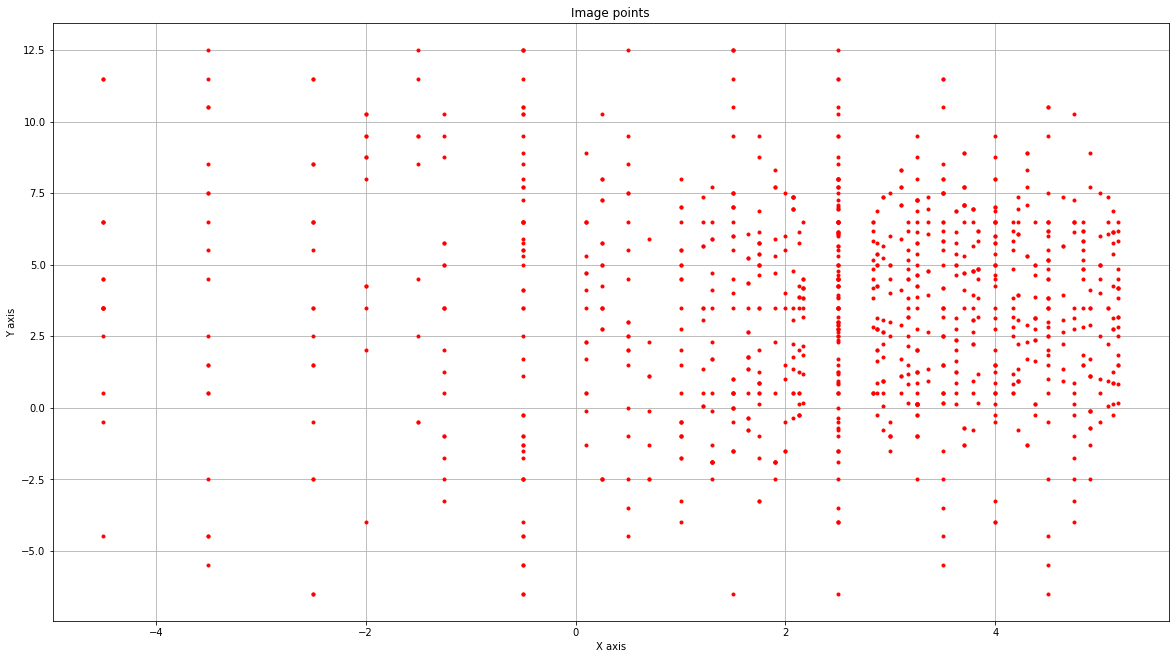

In [8]:
fig = plt.figure(figsize=(20,11))
ax = fig.add_subplot()
ax.plot(x_arr[:,0],x_arr[:,1], color = 'r',ls = "None", marker = ".")
ax.set_title("Image points")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
plt.show()

In [9]:
worldm, worldn = rand_points.T.shape
imagem, imagen = x_arr.shape

In [10]:
#3D DLT
A = []
world_pts = rand_points.T
image_pts = x_arr

for i in range(worldm):
    A.append([-world_pts[i,0],-world_pts[i,1],-world_pts[i,2],-1,0,0,0,0,image_pts[i,0]*world_pts[i,0],image_pts[i,0]*world_pts[i,1],image_pts[i,0]*world_pts[i,2],image_pts[i,0]])
    A.append([0,0,0,0,-world_pts[i,0],-world_pts[i,1],-world_pts[i,2],-1,image_pts[i,1]*world_pts[i,0],image_pts[i,1]*world_pts[i,1],image_pts[i,1]*world_pts[i,2],image_pts[i,1]])

# pass the list A as an array
M = np.asarray(A).reshape(worldm*2,12)
print(M.shape)

(2000, 12)


In [11]:
# SVD 
U, S, Vh = np.linalg.svd(M)

L = Vh[-1,:] / Vh[-1,-2]
#Camera projection matrix:
PEst = L.reshape(3,3+1)
print("Camera Matrix:\n",PEst)

Camera Matrix:
 [[ 3.00000000e+00 -4.35329193e-16  5.50000000e+00 -7.90394567e-15]
 [ 2.39431056e-15  3.00000000e+00  3.50000000e+00  2.31404674e-14]
 [-6.52993790e-16 -1.04070885e-15  1.00000000e+00  4.62537268e-16]]


In [12]:
xEst = np.zeros((worldm,2))
for j in range(worldm):
    X_pts = to_homogeneous(world_pts[j])
    x_aux  = np.dot(PEst,X_pts)
    xEst[j,:] = to_inhomogeneous(x_aux)


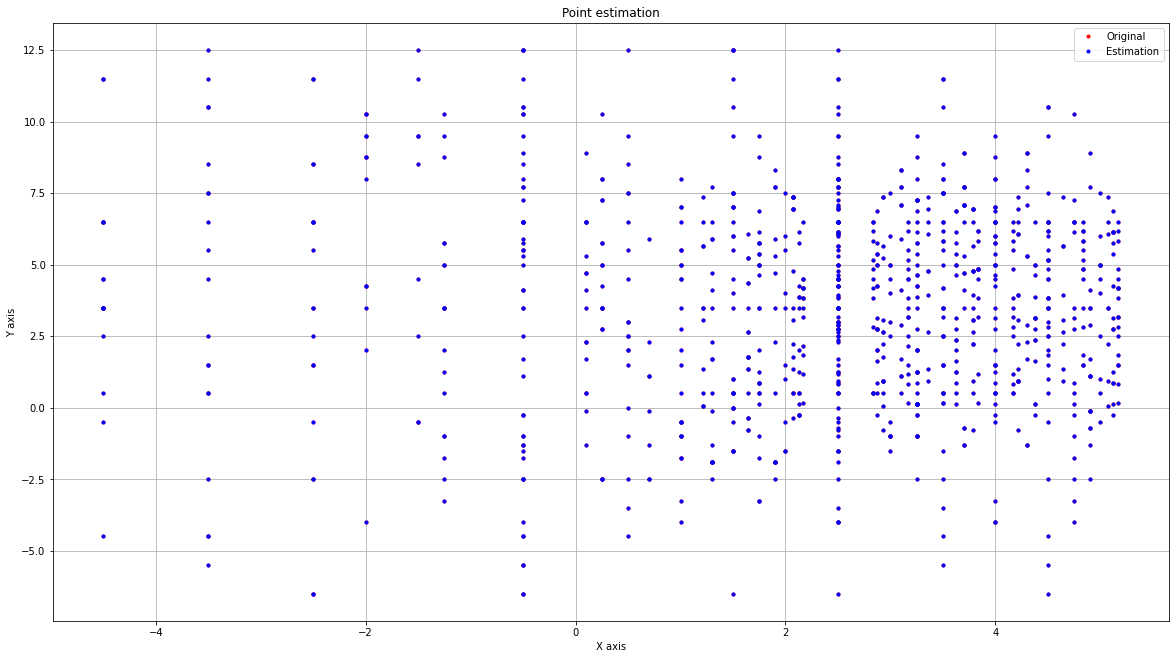

In [13]:
fig = plt.figure(figsize=(20,11))
ax = fig.add_subplot(111)
ax.plot(x_arr[:,0],x_arr[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
ax.set_title("Point estimation")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
ax.plot(xEst[:,0],xEst[:,1], color = 'b',ls = "None", marker = ".", label = 'Estimation')
ax.legend()
plt.show()

In [14]:
err = np.sqrt(np.mean(np.sum(np.square(x_arr-xEst), 1)))
print("Geometric error:",err)

Geometric error: 1.5121709199887778e-14


The geometric error obtained can be considered 0, therefore ideal.